<a href="https://colab.research.google.com/github/Dichik/gathers-nlp-final-project/blob/main/src/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=efcf6fbae8892ca5218d2c1de5e674b26a6ec165c2bdc446f57c35357c224a5e
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
import json

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

In [52]:
def read_file(path: str):
    f = open(path)
    data = json.load(f)
    
    date_info = []
    dataset = []
    for i in data:
        try:
            text = i.get('message')
            dt = i.get('date')
            dataset.append(text)
            date_info.append(dt)
        except:
              print('error')
    
    f.close()
    return pd.DataFrame({'Message': dataset, 'Date': date_info})

In [53]:
regular_news = read_file('regular_news.json')
poss_manipulations = read_file('poss_manipulations.json')

manipulatives = pd.read_csv('manipulatives.csv')
reals = pd.read_csv('reals.csv')
manipulatives['Date'] = None
reals['Date'] = None

In [54]:
regular_news.head()

,Message,Date
0,🤡 У санкт-петербурзі закрили аеропорт через не...,2023-02-28T10:02:45+00:00
1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,2023-02-28T09:40:04+00:00
2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,2023-02-28T09:16:00+00:00
3,,2023-02-28T08:55:02+00:00
4,Влада російської Адигеї заявила про падіння не...,2023-02-28T08:55:02+00:00


In [55]:
poss_manipulations.head()

,Message,Date
0,#ЦПД_аналізує досьє пропагандистки ю.барановсь...,2023-02-27T11:00:05+00:00
1,⏺#ЦПД_застерігає: ворожі медіа поширили «докум...,2023-02-27T09:30:18+00:00
2,⏺#ЦПД_виявляє: станом на ранок 27.02.2023 окуп...,2023-02-27T07:30:51+00:00
3,#ЦПД_розвінчує: Пропагандисти поширюють дезінф...,2023-02-26T19:31:23+00:00
4,,2023-02-26T17:00:38+00:00


In [56]:
poss_manipulations.dropna(inplace=True)

In [57]:
print(reals.isna().sum())
print('~~~~~~~')
print(regular_news.isna().sum())

Unnamed: 0      0
Message       346
Date          445
dtype: int64
~~~~~~~
Message    1
Date       0
dtype: int64


In [58]:
def preclean_text(df, type_text="manipulation"):
    if type_text == 'manipulation':
        manipulation = []
        for i, item in df.iterrows():
            if item[0] is None:
                continue
            for i in range(len(item[0].split('\n'))):
                text = item[0].split('\n')
                if 'Маніп' in text[i]:
                    if 'заявив, що' in text[i+1]:
                        text_split = text[i+1].split('заявив, що')
                        manipulation.append(text_split[1])
                    elif 'заявили, що' in text[i]:
                        text_split = text[i+1].split('заявили, що')
                        manipulation.append(text_split[1])
                    elif 'заявили:' in text[i+1]:
                        text_split = text[i+1].split('заявили:')
                        manipulation.append(text_split[1])
                    elif 'заявив:' in text[i+1]:
                        text_split = text[i+1].split('заявив:')
                        manipulation.append(text_split[1])
                    elif 'повідомив, що' in text[i+1]:
                        text_split = text[i+1].split('повідомив, що')
                        manipulation.append(text_split[1])
                    elif 'повідомили, що' in text[i+1]:
                        text_split = text[i+1].split('повідомили, що')
                        manipulation.append(text_split[1])
                    elif 'повідомив:' in text[i+1]:
                        text_split = text[i+1].split('повідомив:')
                        manipulation.append(text_split[1])
                    elif 'повідомили:' in text[i+1]: 
                        text_split = text[i+1].split('повідомили:')
                        manipulation.append(text_split[1])
                    else:
                        text_split = text[i+1]
                        manipulation.append(text_split)
        print(len(manipulation))
        return pd.DataFrame({'Message': list(set(manipulation))})
                    
    if type_text == 'normal':
        normal = []
        for i, item in df.iterrows():
            if item[0] is None:
                continue
            elif 'тривога' in item[0]:
                continue
            elif 'вибух' in item[0]:
                continue
            
            elif '——' in item[0]:
                    text_split = item[0].split('——')
                    normal.append(text_split[0])
            elif '____' in item[0]:
                    text_split = item[0].split('____')
                    normal.append(text_split[0])
            else:
                    text_split = item[0]
                    normal.append(text_split)
    
        return pd.DataFrame({'Message': list(set(normal))})

In [59]:
df_normal = preclean_text(poss_manipulations, type_text='manipulation')
df_manipulation = preclean_text(regular_news, type_text='normal')

503


In [60]:
df_manipulation.iloc[1].values[0]

'❗️Різниця військового потенціалу між Україною і росією з 24 лютого поступово скорочується\n\nЦЕНТР'

In [61]:
df_manipulation['Message'].astype(bool).sum()

4243

In [62]:
df_manipulation['Message'] = df_manipulation[df_manipulation['Message'].astype(bool)]

In [63]:
df_manipulation.dropna(inplace=True)

In [64]:
df_manipulation.reset_index(drop=True, inplace=True)

In [65]:
df_manipulation.head()

,Message
0,❗️Різниця військового потенціалу між Україною ...
1,🔥За добу ЗСУ ліквідували ще 420 російських оку...
2,🤬 Внаслідок чергового ракетного удару пошкодж...
3,"💡У Києві, Одесі та Дніпрі зранку діють екстрен..."
4,💔 Так нині в Україні проходять спортивні змага...


In [66]:
df_normal.head()

,Message
0,
1,"«українська влада порахувала, скільки грошей ..."
2,«В.Зеленський злякався російської мобілізації...
3,віце-канцлер Австрії Г.Штрахе на мітингу у Ві...
4,"«Американців більше турбують ціни на хліб, га..."


In [67]:
manipulation_news = poss_manipulations[poss_manipulations['Message'].str.contains('Маніпуляці')]
manipulation_news.tail()

,Message,Date
2715,#ЦПД_виявляє: станом на ранок 10.05 окупанти п...,2022-05-10T05:17:48+00:00
2716,#ЦПД_виявляє: протягом дня російські пропаганд...,2022-05-09T19:30:03+00:00
2724,#ЦПД_виявляє: станом на ранок 09.05.2022 року ...,2022-05-09T05:12:22+00:00
3024,"☝🏻ЦПД при РНБО України підтверджує, що путін м...",2022-04-12T14:48:35+00:00
4078,‼️Увага! Маніпуляція!\n\n⚫Російські пропаганди...,2022-02-24T09:50:12+00:00


In [68]:
manipulation_news = manipulation_news.append(manipulatives)[['Message']]
manipulation_news.reset_index(inplace=True)
manipulation_news.drop(columns=['index'], inplace=True)
manipulation_news['Message'] = manipulation_news['Message'].astype(str)
manipulation_news.tail()

,Message
1249,Кремль використовує своїх проксі в Україні для...
1250,nan
1251,Українські військові почали отримувати смс-пов...
1252,Такі повідомлення поширюють російські медіа з ...
1253,Велика Британія та Туреччина планують скупити ...


In [69]:
manipulation_news = manipulation_news[~(manipulation_news['Message'] == 'nan')]
manipulation_news.count()

Message    1249
dtype: int64

In [70]:
reals.reset_index(drop=True, inplace=True)
regular_news.reset_index(drop=True, inplace=True)

In [71]:
df_reals = pd.concat([reals, regular_news], axis=0, ignore_index=True)
df_reals = pd.DataFrame(df_reals, columns=['Message'], dtype=str)
df_reals.tail(5)

,Message
6440,
6441,
6442,"росія, ймовірно, готується до широкомасштабног..."
6443,Жодного дня на росії спокійного не буває😈\n\nЦ...
6444,🇵🇱 Польський Сейм визнав росію державою-спонсо...


In [72]:
df_reals = df_reals[~(df_reals['Message'] == 'nan')]
df_reals.count()

Message    6099
dtype: int64

In [73]:
df_reals['is_manipulation'] = 0
manipulation_news['is_manipulation'] = 1

<ipython-input-73-1e322b566fe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manipulation_news['is_manipulation'] = 1


In [74]:
dataset = pd.concat([df_reals, manipulation_news])

df = pd.DataFrame(dataset, columns=['Message', 'is_manipulation'])
df.reset_index(drop=True, inplace=True)
df.head()

,Message,is_manipulation
0,У Сеймі справді виконували гімн України на зна...,0
1,"Італійський рис справді потрапив до України, о...",0
2,Твердження про зашифровані символи у кількості...,0
3,На неї звернули увагу аналітики проєкту VoxChe...,0
4,На неї звернули увагу аналітики проєкту The In...,0


In [75]:
df.isna().sum()

Message            0
is_manipulation    0
dtype: int64

In [76]:
df['Message'] = df['Message'].astype(str)
df.head()

,Message,is_manipulation
0,У Сеймі справді виконували гімн України на зна...,0
1,"Італійський рис справді потрапив до України, о...",0
2,Твердження про зашифровані символи у кількості...,0
3,На неї звернули увагу аналітики проєкту VoxChe...,0
4,На неї звернули увагу аналітики проєкту The In...,0


In [77]:
df['is_manipulation'].value_counts()

0    6099
1    1249
Name: is_manipulation, dtype: int64

In [40]:
f = open('stop_words.txt')

stop_words = []
for word in f:
  stop_words.append(word)

stop_words.extend(['re', 'edu', 'inst', 'https', 'також'])
len(stop_words)

1988

In [79]:
!pip install uk-stemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement uk-stemmer (from versions: none)
ERROR: No matching distribution found for uk-stemmer


In [142]:
nltk.download('punkt')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# stemming / lemmatization? - we have Україна, України, etc. in wordcloud

def process_row(input, join_back=True):

    if isinstance(input, str):
        tokens = tokenizer.tokenize(input)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 3 and not w.startswith("цпд_")]
        if len(filtered_words) > 0 and filtered_words[-1] == 'центр':
          filtered_words = filtered_words[:len(filtered_words) - 1]

        input = " ".join(filtered_words)
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}]+", " ", input)
        input = re.sub(r"#\S+", "", input)

        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        
        input = input.strip()
        input = input.lower()
        input = input.replace("центр", '')
    return input


# import nltk
# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
# from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')

# def process_row(text):
#     # Lowercase
#     text = text.lower()
#     # Remove punctuation
#     text = "".join(c for c in text if c not in ('!','.',',',':',';','-','–',')','('))
#     # Tokenize
#     tokens = word_tokenize(text)
#     tokens = [t for t in tokens if t not in stop_words]
#     # Stemming
#     # stemmer = SnowballStemmer('ukrainian')
#     stemmed_tokens = [stemmer.stem(t) for t in tokens]
#     # Join the tokens back into a single string
#     text = " ".join(stemmed_tokens)
#     return text

df['cleaned_text'] = df['Message'].apply(lambda x: process_row(str(x)))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Message,is_manipulation,cleaned_text
3750,🚀 Україна отримає ЗРК Patriot до середини весн...,0,укра на отрима patriot середини весни подоляк ...
2634,🇪🇸 Іспанія приєднається до європейського плану...,0,спан я при дна ться вропейського плану передач...
4855,🫡 Залужний як стан мільйонів українців сьогодн...,0,залужний стан м льйон в укра нц в сьогодн
4957,Сполучені Штати ще до початку російського втор...,0,сполучен штати початку рос йського вторгнення ...
2587,⚡️Запорізька область — робота ППО.\n\nЦЕНТР,0,запор зька область робота


In [81]:
df.dropna(inplace=True)
df.head()

,Message,is_manipulation,cleaned_text
0,У Сеймі справді виконували гімн України на зна...,0,сейм справд виконували г мн укра ни знак сол д...
1,"Італійський рис справді потрапив до України, о...",0,тал йський справд потрапив укра ни однак того ...
2,Твердження про зашифровані символи у кількості...,0,твердження зашифрован символи к лькост танк в ...
3,На неї звернули увагу аналітики проєкту VoxChe...,0,звернули увагу анал тики про кту voxcheck вони...
4,На неї звернули увагу аналітики проєкту The In...,0,звернули увагу анал тики про кту insider вони ...


In [82]:
df = df[df['Message'].apply(len) > 3]
df.head()

,Message,is_manipulation,cleaned_text
0,У Сеймі справді виконували гімн України на зна...,0,сейм справд виконували г мн укра ни знак сол д...
1,"Італійський рис справді потрапив до України, о...",0,тал йський справд потрапив укра ни однак того ...
2,Твердження про зашифровані символи у кількості...,0,твердження зашифрован символи к лькост танк в ...
3,На неї звернули увагу аналітики проєкту VoxChe...,0,звернули увагу анал тики про кту voxcheck вони...
4,На неї звернули увагу аналітики проєкту The In...,0,звернули увагу анал тики про кту insider вони ...


In [6]:
df = pd.read_csv('/content/text_preproc.csv')
df.head()

,Unnamed: 0,Message,is_manipulation,light_clean,lemmatized,hard_clean,lemmatized_hard,hard_clean_remove
0,0,🤡 У санкт-петербурзі закрили аеропорт через не...,0,У санкт-петербурзі закрили аеропорт через неві...,у санкт - петербург закрити аеропорт через нев...,санкт петербурзі закрили аеропорт невідомий об...,санкт петербург закрити аеропорт невідомий об'...,об'єкт введено «килим» «база» «килим» подають
1,1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,0,Тепер збирають «на священну війну». Шахраї в р...,"тепер збирати "" на священний війна "" . шахрай ...",збирають «на священну війну» шахраї рясах знай...,"збирати "" на священний війна "" шахрай ряса зна...",«на війну»
2,2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,0,Уночі росіяни обстріляли Святогірськ і влучили...,уночі росіянин обстріляли святогірськ і влучит...,уночі росіяни обстріляли святогірськ влучили ч...,уночі росіянин обстріляли святогірськ влучити ...,святогірськ
3,3,Влада російської Адигеї заявила про падіння не...,0,Влада російської Адигеї заявила про падіння не...,влада російський адигеї заявити про падіння не...,влада російської адигеї заявила падіння невідо...,влада російський адигея заявити падіння невідо...,схожих
4,4,😄 На росії від самого ранку знову тривога\n\nВ...,0,На росії від самого ранку знову тривога. В ефі...,на росія від самий ранок знову тривога . в ефі...,росії ранку тривога ефірі руського радіо попер...,росія ранок тривога ефірі руський радіо попере...,ефірі


In [42]:
df = df[~df.isna()]

In [43]:
X = df['hard_clean']
y = df['is_manipulation']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [44]:
X.isna().sum()

0

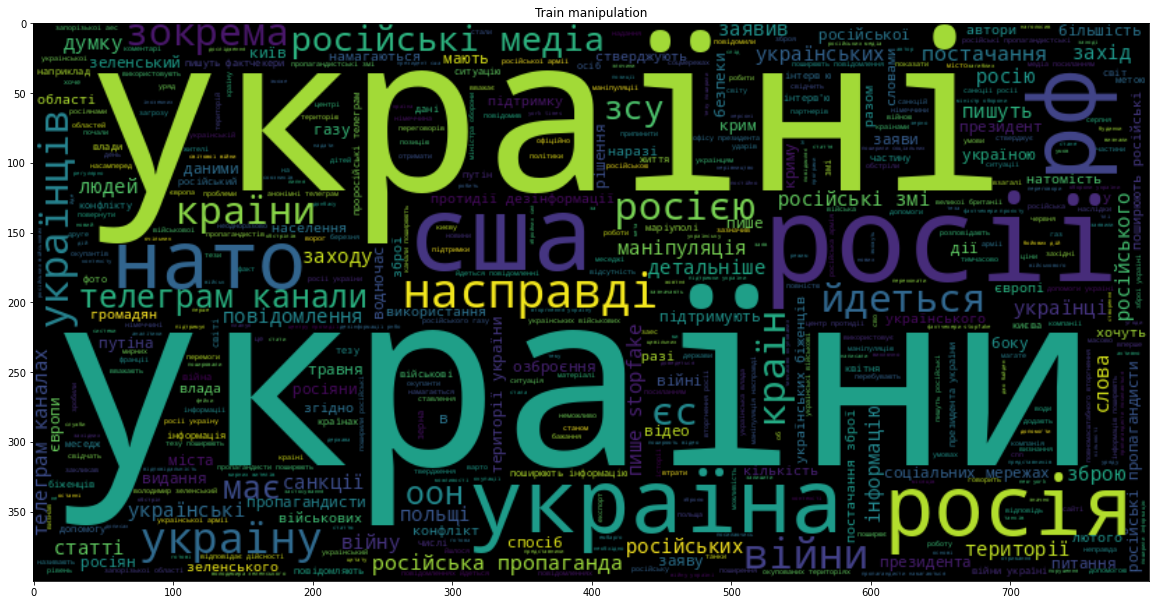

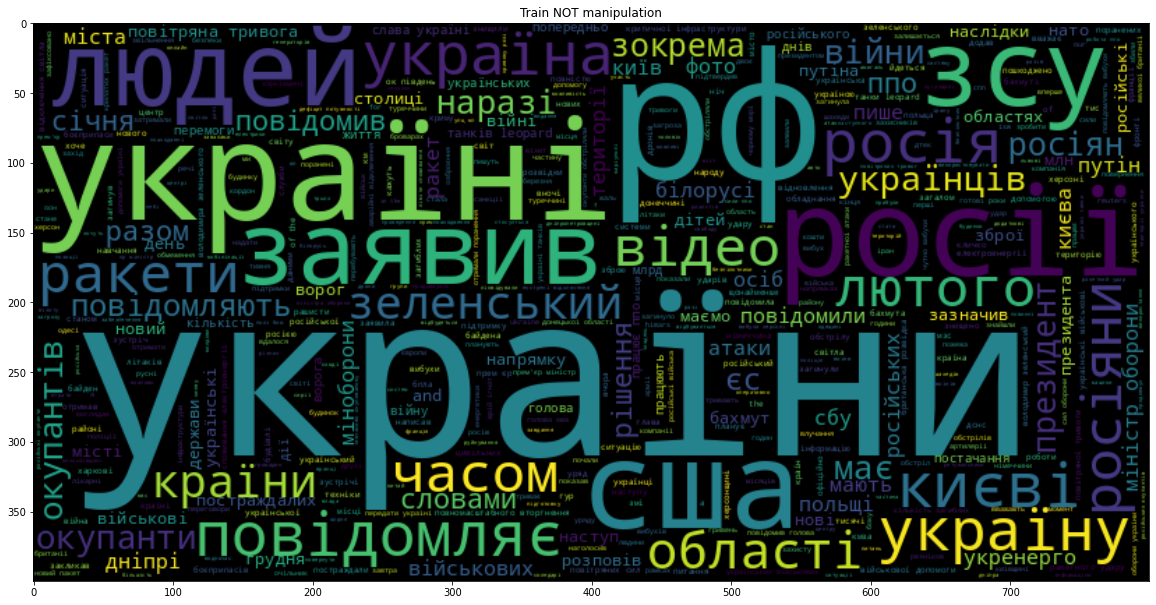

In [45]:
plt.figure(figsize = (20,20)) 
plt.title("Train manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 1, 'hard_clean']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Train NOT manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 0, 'hard_clean']))
plt.imshow(wc, interpolation = 'bilinear')

In [9]:
def comp_metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = roc_auc_score(y_true, y_pred)
    print(f"Result Roc Auc: {class_roc_aucs}")
    return class_roc_aucs, np.mean(class_roc_aucs)

## Clustering

In [11]:
sent_emb_model = SentenceTransformer("paraphrase-MiniLM-L6-v2", device="cpu")
news_embeddings = sent_emb_model.encode(df["hard_clean"].to_list(), show_progress_bar=True, batch_size=100)

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [13]:
df["hard_clean"].isna().sum()

2

In [14]:
df = df[~df["hard_clean"].isna()]
df["hard_clean"].isna().sum()

0

In [15]:
from sklearn.utils import shuffle
df = shuffle(df)

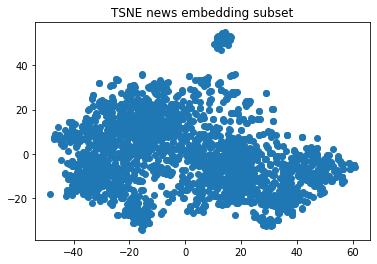

In [16]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(news_embeddings[:2000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


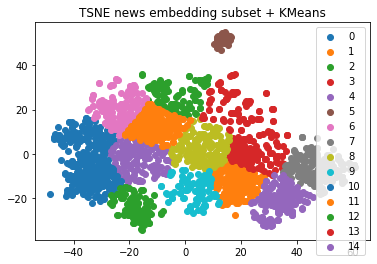

In [17]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=15, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [65]:
df.iloc[:2000][kmeans_clusts_news_embeddings_subset == 5].Message.to_list()

['💥 У Севастополі зранку тривожно: вибухи чули поблизу районів, де розташовані російські військові частини, — пишуть місцеві пабліки \n\nЦЕНТР',
 '⚡️За одну годину на Заході Грузії сталися три землетруси\n\nНайпотужніший поштовх був магнітудою 4.2.\n\nЦЕНТР',
 '🚫 росія припиняє постачання нафти трубопроводом до Польщі, — повідомляє компанія PLN Orlen\n\nЗупинка поставок трубопроводом, звільненим від антиросійських санкцій ЄС, сталася наступного дня після того, як Польща поставила Україні свої перші танки Leopard 2.\n\nЦЕНТР',
 '👏Глава Єврокомісії перед самітом Україна-ЄС: підтримуємо українців без жодних «якщо» і «але», – Reuters.\n\nЦЕНТР',
 'У росії вичерпуються боєприпаси і вона зазнала значних бойових втрат, — шеф Пентагону для CNN.\n\nЦЕНТР',
 '⚡️У Парижі відбулася масова акція протесту проти пенсійної реформи\n\nРеформа передбачає підняття пенсійного віку з 62 років до 64. На протест вийшло близько 500 тис людей. Навіть відбулись сутички з поліцією.\n\nЦЕНТР',
 '💔 З імбирного печ

In [19]:
df.iloc[:2000][kmeans_clusts_news_embeddings_subset == 1].Message.to_list()

[' «провідні італійські ЗМІ продовжують опрацьовувати своє населення в руслі установок київської пропаганди. Тим самим рядові жителі країни позбавляються права на критичний аналіз інформації про ситуацію в Україні, в т.ч. із зони конфлікту».\xa0 ',
 '⚡️Вночі рф обстріляли одну з лікарень Херсону\n\nПошкоджено пологове, приймальне та онкологічне відділення. В момент атаки у лікарні перебували медики та близько 120 пацієнтів. На щастя, ніхто не постраждав.\n\nЦЕНТР',
 '⚡️Голова Євроради Шарль Мішель прибув до Києва на саміт Україна-ЄС\n\nЦЕНТР',
 '😱У Британії близько 500 тис людей взяли участь у найбільшому за 10 років страйку, – Reuters\n\nЧерез страйк у країні закрито школи, припинено більшість залізничних перевезень.\n\nПожежники, медики, вчителі виходять на вулиці, аби домогтися підвищення зарплатні.\n\nЦЕНТР',
 "😈 Наша улюблена статистика під'їхала від Генштабу ЗСУ \n\nЦЕНТР",
 '🐆 Що там із танками Leopard 2? Підсумки сьогоднішнього «Рамштайну-8»\n\nДавайте підсумуємо сьогоднішні «т

In [20]:
df.iloc[:2000][kmeans_clusts_news_embeddings_subset == 5].Message.to_list()

['💥 У Севастополі зранку тривожно: вибухи чули поблизу районів, де розташовані російські військові частини, — пишуть місцеві пабліки \n\nЦЕНТР',
 '⚡️За одну годину на Заході Грузії сталися три землетруси\n\nНайпотужніший поштовх був магнітудою 4.2.\n\nЦЕНТР',
 '🚫 росія припиняє постачання нафти трубопроводом до Польщі, — повідомляє компанія PLN Orlen\n\nЗупинка поставок трубопроводом, звільненим від антиросійських санкцій ЄС, сталася наступного дня після того, як Польща поставила Україні свої перші танки Leopard 2.\n\nЦЕНТР',
 '👏Глава Єврокомісії перед самітом Україна-ЄС: підтримуємо українців без жодних «якщо» і «але», – Reuters.\n\nЦЕНТР',
 'У росії вичерпуються боєприпаси і вона зазнала значних бойових втрат, — шеф Пентагону для CNN.\n\nЦЕНТР',
 '⚡️У Парижі відбулася масова акція протесту проти пенсійної реформи\n\nРеформа передбачає підняття пенсійного віку з 62 років до 64. На протест вийшло близько 500 тис людей. Навіть відбулись сутички з поліцією.\n\nЦЕНТР',
 '💔 З імбирного печ

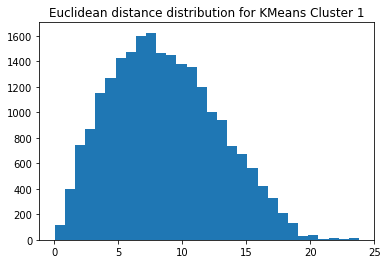

In [21]:
estimated_dists = pairwise_distances(
    tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == 1]
).flatten()

plt.title("Euclidean distance distribution for KMeans Cluster 1")
plt.hist(estimated_dists[estimated_dists != 0], bins=30)
plt.show()

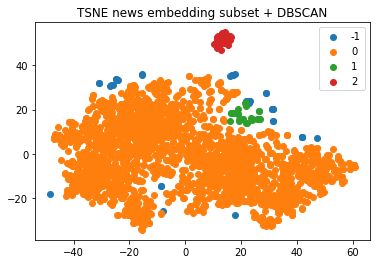

In [22]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=4,
    min_samples=10
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [63]:
df.iloc[:2000][dbscan_clusts_news_embeddings_subset == 2].Message.to_list()[:10]

['💥 У Севастополі зранку тривожно: вибухи чули поблизу районів, де розташовані російські військові частини, — пишуть місцеві пабліки \n\nЦЕНТР',
 '⚡️За одну годину на Заході Грузії сталися три землетруси\n\nНайпотужніший поштовх був магнітудою 4.2.\n\nЦЕНТР',
 '🚫 росія припиняє постачання нафти трубопроводом до Польщі, — повідомляє компанія PLN Orlen\n\nЗупинка поставок трубопроводом, звільненим від антиросійських санкцій ЄС, сталася наступного дня після того, як Польща поставила Україні свої перші танки Leopard 2.\n\nЦЕНТР',
 '👏Глава Єврокомісії перед самітом Україна-ЄС: підтримуємо українців без жодних «якщо» і «але», – Reuters.\n\nЦЕНТР',
 'У росії вичерпуються боєприпаси і вона зазнала значних бойових втрат, — шеф Пентагону для CNN.\n\nЦЕНТР',
 '⚡️У Парижі відбулася масова акція протесту проти пенсійної реформи\n\nРеформа передбачає підняття пенсійного віку з 62 років до 64. На протест вийшло близько 500 тис людей. Навіть відбулись сутички з поліцією.\n\nЦЕНТР',
 '💔 З імбирного печ

In [64]:
df.iloc[:2000][dbscan_clusts_news_embeddings_subset == 1].Message.to_list()[:10]

['❗️❗️ Головні заяви зі спільної пресконференції Зеленського та Байдена в Білому домі\n\n🇺🇸 Основні заяви Байдена:\n\n— Україна виграла боротьбу за Київ, виграла боротьбу за Херсон, виграла боротьбу за Харків — Україна перевершила очікування росії.\n— Скільки б це не коштувало, американський народ підтримуватиме Україну.\n— США виділяють Україні додаткову військову допомогу на $1,85 млрд, вона включає системи ЗРК Patriot.\n— Чекаємо на підписання 45 мільярдів додаткової допомоги для України.\n— путін хотів роз‘єднати НАТО — насправді путін тільки об‘єднав НАТО. Я ще не бачив, щоб НАТО або ЄС були б більш згуртованими, аніж зараз.\n— У нас спільне бачення — вільна незалежна процвітаюча Україна. Україна може досягти успіху на полі бою з нашою допомогою, з допомогою союзників.\n\n🇺🇦 Основні заяви Зеленського:\n\n— Повертаюсь в Україну з хорошими новинами.\n— За 300 днів цієї війни ми вийшли на новий рівень союзництва, який на 100% наповнено реальним змістом.\n— Сподіваюся, що Конгрес США 

## TF-IDF

In [25]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["hard_clean"].iloc[:6005]
)
print(tf_idf_object.get_feature_names_out().tolist())
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")

['abc', 'abh', 'ability', 'about', 'abrams', 'absolute', 'absolutely', 'accent', 'according', 'achieve', 'achieved', 'achievements', 'achmatowisch', 'act', 'actions', 'addressed', 'adrienne', 'adventure', 'affairs', 'afp', 'afraid', 'after', 'ag', 'again', 'against', 'againstsanctions', 'agence', 'aggression', 'aggressor', 'aggressors', 'agn', 'agoravox', 'aid', 'aiding', 'air', 'airbaltic', 'airbus', 'airlines', 'akeron', 'akhmadovitch', 'al', 'alexander', 'ali', 'alina', 'aljazeera', 'all', 'allgemeine', 'almost', 'along', 'already', 'also', 'altius', 'alves', 'always', 'am', 'america', 'american', 'amnesty', 'among', 'amwajmedia', 'amx', 'an', 'anadolu', 'and', 'andriy', 'android', 'andré', 'ansa', 'antena', 'any', 'anyone', 'anything', 'ap', 'apart', 'appeal', 'appeared', 'aquaree', 'arabia', 'arabiya', 'archer', 'ard', 'are', 'arm', 'armed', 'army', 'arsen', 'art', 'artillery', 'as', 'ashamed', 'ask', 'aspide', 'assistants', 'associated', 'aster', 'at', 'atacms', 'atlas', 'attack'

In [26]:
list_drop = []
for i, el in enumerate(tf_idf_object.get_feature_names_out().tolist()):
    if el == 'аарон':
        for ell in tf_idf_object.get_feature_names_out().tolist()[:i]:
            list_drop.append(ell)

In [27]:
index_drop = []
for it in list_drop:
    # print(it)
    # print('-'*80)
    for i, item in df.iterrows():
        # print(item[0])
        if it in item[0]:
            # print(it)
            # print(item[0])
    # df["cleaned_text"].str.contains(it))
            index_drop.append(df.loc[df['Message'] == item[0]].index.values[0])
# df.head()

In [28]:
df.drop(index_drop, inplace=True)

In [29]:
df.head()

,Unnamed: 0,Message,is_manipulation,light_clean,lemmatized,hard_clean,lemmatized_hard,hard_clean_remove
135,135,💥 Повідомляють про підрив дамби на Північному ...,0,Повідомляють про підрив дамби на Північному Ст...,повідомляти про підрив дамба на північний став...,повідомляють підрив дамби північному ставку ок...,повідомляти підрив дамба північний ставка окол...,дамби сповільнити «вагнер» ягідного
4782,4782,«провідні італійські ЗМІ продовжують опрацьов...,1,«провідні італійські ЗМІ продовжують опрацьову...,""" провідний італійський змі продовжувати опрац...",«провідні італійські змі продовжують опрацьову...,""" провідний італійський змі продовжувати опрац...",«провідні критичний конфлікту»
3964,3964,"⚡️ЄС заблокував €22 млрд для Угорщини, доки її...",0,"ЄС заблокував €22 млрд для Угорщини, доки її у...","єс заблокувати € 22 млрд для угорщина , доки ї...",єс заблокував € млрд угорщини уряд виконає умо...,єс заблокувати € млрд угорщина уряд виконає ум...,€ пов'язані правами
2851,2851,"❗️ У передмісті Києва, на Софіївській Борщагів...",0,"У передмісті Києва, на Софіївській Борщагівці,...","у передмісті київ , на софіївський борщагівка ...",передмісті києва софіївській борщагівці виникл...,передмісті київ софіївський борщагівка виникну...,NaN
2249,2249,⚡️Президент Казахстану розпустив парламент та ...,0,Президент Казахстану розпустив парламент та пр...,президент казахстан розпустити парламент та пр...,президент казахстану розпустив парламент призн...,президент казахстан розпустити парламент призн...,необхідне


In [31]:
df.loc[df["hard_clean"].str.contains('3wkfgmpbdzc')]

,Unnamed: 0,Message,is_manipulation,light_clean,lemmatized,hard_clean,lemmatized_hard,hard_clean_remove


In [32]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["hard_clean"].iloc[:6005]
)
print(tf_idf_object.get_feature_names_out().tolist())
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
# print(
#     f"Text : {df['cleaned_text'].iloc[1]}\n"
#     f"Vectorization: {tf_idf_object.transform([df['cleaned_text'].iloc[1]]).toarray()[0]}"
# )

['abc', 'abh', 'ability', 'about', 'abrams', 'absolute', 'absolutely', 'accent', 'according', 'achieve', 'achieved', 'achievements', 'achmatowisch', 'act', 'actions', 'addressed', 'adrienne', 'adventure', 'affairs', 'afp', 'afraid', 'after', 'ag', 'again', 'against', 'againstsanctions', 'agence', 'aggression', 'aggressor', 'aggressors', 'agn', 'agoravox', 'aid', 'aiding', 'air', 'airbaltic', 'airbus', 'airlines', 'akeron', 'akhmadovitch', 'al', 'alexander', 'ali', 'alina', 'aljazeera', 'all', 'allgemeine', 'almost', 'along', 'already', 'also', 'altius', 'alves', 'always', 'am', 'america', 'american', 'amnesty', 'among', 'amwajmedia', 'amx', 'an', 'anadolu', 'and', 'andriy', 'android', 'andré', 'ansa', 'antena', 'any', 'anyone', 'anything', 'ap', 'apart', 'appeal', 'appeared', 'aquaree', 'arabia', 'arabiya', 'archer', 'ard', 'are', 'arm', 'armed', 'army', 'arsen', 'art', 'artillery', 'as', 'ashamed', 'ask', 'aspide', 'assistants', 'associated', 'aster', 'at', 'atacms', 'atlas', 'attack'

## Logistic Regression

In [49]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(X_train, y_train)]
# FIXME add k-fold

In [47]:
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("lof_reg", LogisticRegression())
])
all_train_pred = model.fit(
    X_train, 
    y_train
).predict_proba(X_train)

all_train_pred = np.stack([el[1] for el in all_train_pred])

comp_metric(y_train.values, all_train_pred)

Result Roc Auc: 0.9999943875482145


(0.9999943875482145, 0.9999943875482145)

In [50]:

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    parameters = {
        'model__C': [.01, .1, 1, 10],
        'model__penalty': ['l1', 'l2']
    }
    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer()),
        ("model", LogisticRegression())
    ])
    # print(LogisticRegression().get_params().keys())
    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=parameters)
    grid.fit(X_train.iloc[train_ids], y_train.iloc[train_ids])
    fold_train_preds = grid.predict_proba(X_train.iloc[train_ids])
    fold_train_preds = np.stack([el[1] for el in fold_train_preds])
    fold_test_preds = grid.predict_proba(X_train.iloc[test_ids])
    fold_test_preds = np.stack([el[1] for el in fold_test_preds])
    fold_train_targets = y_train.iloc[train_ids].values
    fold_test_targets = y_train.iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets, fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets, fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(grid)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 0
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9363302139037432


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 1
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9625950786918575


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 2
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9571488660661083


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 3
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 0.9372217743348873


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 4
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9553787374250762


## RNN

In [51]:
class RNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        rnn_channels = 256,
        hidden_size = 512,
        rnn_type=nn.GRU,
    ):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels) 
        self.rnns = rnn_type(
            rnn_channels, 
            hidden_size, 
            batch_first=True,
            num_layers=1,
        )
        self.hidden_size = hidden_size
        self.classifier = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        x, _ = self.rnns(x, h0)
        x =  x.mean(1)
        # x = x[:, -1, :]
        x = self.classifier(x)
        return x
        
        

In [52]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="first"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            self.targets[idx]
        )
    
    def __len__(self):
        return len(self.texts)

In [53]:
!python -m spacy download ru_core_news_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-06 16:24:52.648522: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-06 16:24:52.648686: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-06 16:24:52.648709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [54]:
tokenizer = get_tokenizer('spacy', language='ru_core_news_sm')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(X_train), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

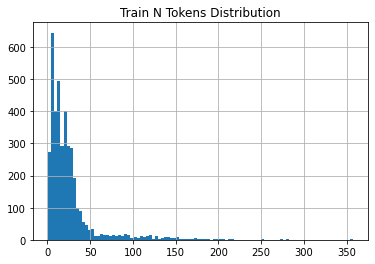

0.5 Quantile of N tokens: 17.0


In [55]:
train_n_tokens = X_train.apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.5 Quantile of N tokens: {np.quantile(train_n_tokens, 0.50)}")


In [56]:
train_torch_dataset = TextDataset(
    texts=X_train.iloc[folds_train_test_ids[0][0]].to_list(),
    targets=y_train.iloc[folds_train_test_ids[0][0]].to_list(),
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=50,
)

train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=X_train.iloc[folds_train_test_ids[0][1]].to_list(),
    targets=y_train.iloc[folds_train_test_ids[0][1]].to_list(),
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=50,
)

valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True,
    pin_memory=True
)

test_torch_dataset = TextDataset(
    texts=X_test.to_list(),
    targets=y_test.to_list(),
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=50,
)

test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

In [57]:

def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            if mode == "train":
                inp_optimizer.zero_grad()
            predicted_label = inp_model(text)
            predicted_label = torch.squeeze(torch.sigmoid(predicted_label))
            loss = criterion(predicted_label, label.float())
            if mode == "train":
                loss.mean().backward()
                optimizer.step()
                
            all_predicted_label.append(predicted_label.detach().numpy())
            all_losses.append(loss.item())
            all_targets.append(label.detach().numpy().astype(np.float32))

    all_predicted_label = np.concatenate(all_predicted_label, axis = 0)
    all_losses = np.array(all_losses)
    all_targets = np.concatenate(all_targets, axis = 0)

    return all_predicted_label, all_losses, all_targets

In [58]:
nn_model = RNN(
    num_embeddings=len(vocab),
 )

criterion = nn.BCELoss()
# TODO: Try to tune hyperparameters here
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [59]:
n_epochs = 5

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    train_roc_auc = roc_auc_score(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("roc_aur", train_roc_auc)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_roc_auc = roc_auc_score(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("roc_aur", valid_roc_auc)

    # 3. Update learning rate (if needed)
    scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

Starting Epoch 1
Train phase


100%|██████████| 198/198 [01:14<00:00,  2.65it/s]


roc_aur 0.8487592114292224
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.34it/s]


roc_aur 0.9385732978387403
Starting Epoch 2
Train phase


100%|██████████| 198/198 [01:16<00:00,  2.60it/s]


roc_aur 0.9691200434396265
Valid phase


100%|██████████| 49/49 [00:05<00:00,  8.19it/s]


roc_aur 0.9516130487749853
Starting Epoch 3
Train phase


100%|██████████| 198/198 [01:11<00:00,  2.76it/s]


roc_aur 0.9962847396746563
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.21it/s]


roc_aur 0.9560528809276723
Starting Epoch 4
Train phase


100%|██████████| 198/198 [00:55<00:00,  3.59it/s]


roc_aur 0.9996134890657219
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.32it/s]


roc_aur 0.9454947434914046
Starting Epoch 5
Train phase


100%|██████████| 198/198 [00:56<00:00,  3.50it/s]


roc_aur 0.9998003856262168
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.37it/s]

roc_aur 0.9457744890132203
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.


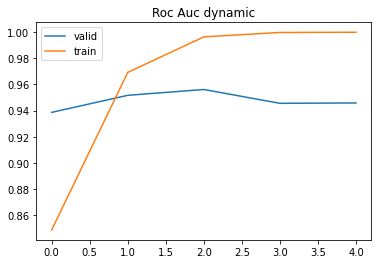

In [60]:
plt.title("Roc Auc dynamic")
plt.plot(valid_roc_aucs, label="valid")
plt.plot(train_roc_aucs, label="train")
plt.legend()
plt.show()

In [62]:
nn_model.load_state_dict(best_model_state_dict)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    mode="eval"
)

print("Test metrics")
print(roc_auc_score(
    test_targets, 
    test_labels
))

100%|██████████| 62/62 [00:10<00:00,  6.16it/s]

Test metrics
0.9514634986225896


## Save RNN model

In [66]:
import pickle

with open('rnn_model.pkl', 'wb') as f:
    pickle.dump(nn_model, f)

In [68]:
with open('rnn_model.pkl', 'rb') as f:
    model = pickle.load(f)

## References

- https://github.com/skupriienko/Ukrainian-Stopwords